1. Lookback window 사이즈를 다르게 주자

2. 리벨런싱 주기를 다르게

3. max_ratio를 다르게

4. Shrinkage Method를 다르게

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ray

from optimize_multi.object_function import * 
from optimize_multi.optimizer_v2 import run_optimizer
from optimize_multi.backtest import simulate_strategy

from ryu_tool.mytool import draw_return_result, print_statistics, run_alpha_regression

2023-05-27 11:39:23,604	INFO worker.py:1625 -- Started a local Ray instance.


In [252]:
# 필요한 데이터 불러오기
rtn = pd.read_pickle("Data/ETF_final.pickle").pct_change(fill_method=None).fillna(0)
rtn

,TLT,SHY,GLD,GSG,VNQ,BIL,DBA,IJS,QQQ,SPY,VWO
2007-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-06-01,-0.009146,-0.004121,0.013732,0.008981,0.001393,0.000218,0.001518,0.010276,0.000635,0.004957,0.022675
2007-06-04,0.004557,0.000376,0.001505,0.012750,0.004048,0.000218,-0.006063,0.001453,0.002964,0.000130,-0.003135
2007-06-05,-0.006281,-0.000878,-0.002555,-0.002209,-0.015873,0.000000,0.003050,-0.008464,0.000000,-0.003958,-0.005392
2007-06-06,-0.000468,0.001255,0.000603,0.000548,-0.006784,0.000436,-0.007602,-0.011951,-0.010553,-0.010750,-0.016716
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,0.014704,0.003901,0.005086,-0.018155,-0.009871,-0.000109,-0.003324,-0.027506,-0.018864,-0.015874,-0.017043
2023-04-26,-0.010658,-0.001214,-0.005437,-0.020490,-0.009600,0.000218,0.001429,-0.008832,0.006065,-0.004236,0.006884
2023-04-27,-0.009923,-0.001945,0.000054,0.001531,0.022617,0.000327,-0.001903,0.017144,0.027191,0.019908,0.012915
2023-04-28,0.016131,0.001096,0.000271,0.014264,0.012274,0.000000,-0.001430,0.012974,0.006899,0.008535,0.006000


In [253]:
# 자산 드롭 (선택)
#rtn_drop = rtn.drop(["SHY","BIL","VNQ"], axis=1)
#rtn = rtn_drop


rtn_drop = rtn.drop(["SHY","BIL","VNQ", "DBA","IJS","QQQ", "VWO"], axis=1)
rtn = rtn_drop

In [254]:
# Ray를 사용하기 위해 Ray데이터 생성
#rtn_ray = ray.put(rtn)
rtn_ray = ray.put(rtn_drop)

In [255]:
# S&P500 마켓 데이터 (결과 비교를 위해)
spx = pd.read_csv("Data/spx_hist.csv", 
                  index_col=0,
                  parse_dates=True).pct_change(fill_method=None)

# Investing.com에서 받아와서 그런지 Timestamp에 문제가 있다
problem = [pd.Timestamp('2021-07-03 00:00:00'),
           pd.Timestamp('2021-07-04 00:00:00'),
           pd.Timestamp('2021-07-05 00:00:00'),
           pd.Timestamp('2021-08-07 00:00:00'),
           pd.Timestamp('2021-08-08 00:00:00')]

spx = spx.drop(problem)

In [256]:
look_back_list = [100, 200, 300, 400, 500, 600, 700]
#look_back_list2 = [90, 110, 130, 150, 170]
#args_lst = [0.1, 1, 3, 5, 10, 20]
l_list = [0, 0.05, 0.1]

In [257]:
for_loop = look_back_list

In [258]:
rtn_drop.columns

Index(['TLT', 'GLD', 'GSG', 'SPY'], dtype='object')

In [259]:
# ETF Optimizing
futures = [run_optimizer.remote(obj_function=obj_sharpe, 
                                rtn_df=rtn_ray,
                                spx_mask="None",
                                start_year="2008",
                                end_year="2023",
                                rebalancing="M",
                                look_back_size=arg,
                                max_ratio=0.3,
                                min_ratio=0,
                                shrinkage_method="None",
                                arg=0.5)  for arg in look_back_list]
result = ray.get(futures)

100%|██████████| 180/180 [00:00<00:00, 333.25it/s] [repeated 2x across cluster]


In [260]:
result_dict = {}
weight_dict = {}

for i, arg in enumerate(for_loop):
    rt, weig = simulate_strategy(result[i], rtn, fee_rate=0.0015)
    result_dict[f"{arg} Days"] = rt
    weight_dict[str(arg)] = weig

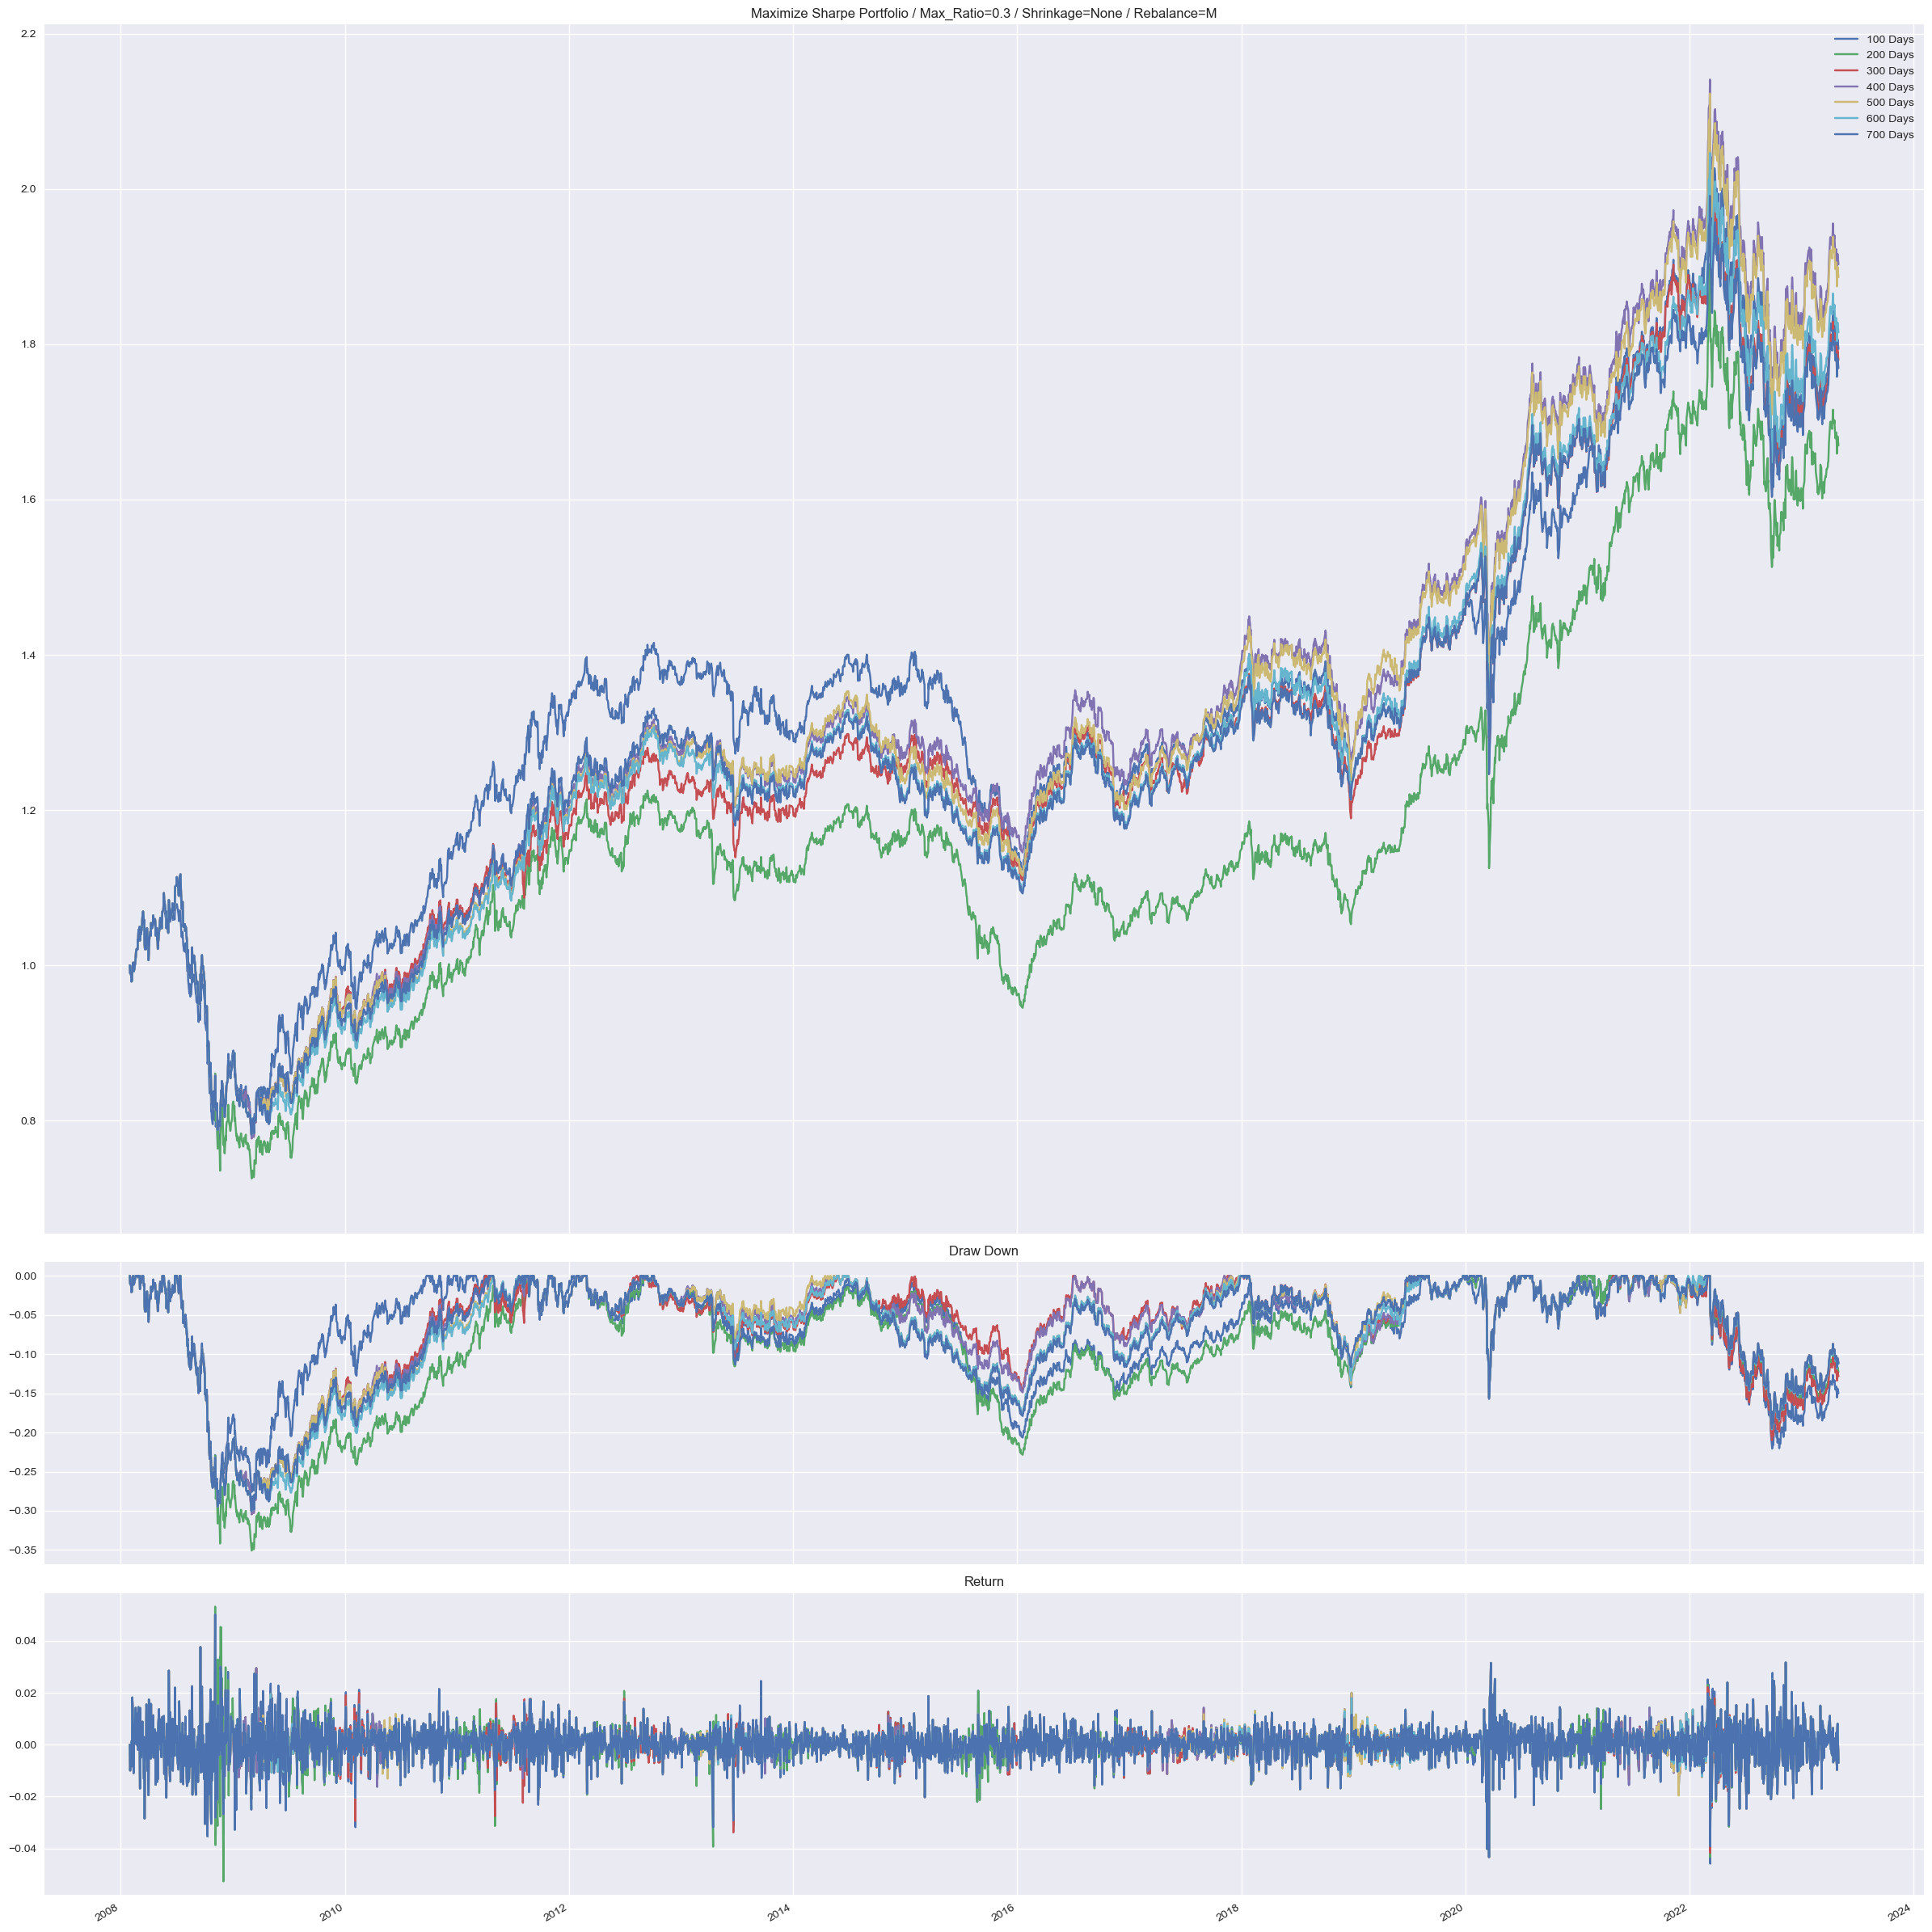

In [261]:
draw_return_result(result_dict,
                   one_plot=True,
                   title="Maximize Sharpe Portfolio / Max_Ratio=0.3 / Shrinkage=None / Rebalance=M")

In [222]:
stats = print_statistics(result_dict)
stats.columns = [f"{day} Days" for day in for_loop]
stats

,100 Days,200 Days,300 Days,400 Days,500 Days,600 Days,700 Days
CAGR,0.048400,0.042500,0.048600,0.054000,0.060900,0.067300,0.058900
Mean,0.056220,0.050260,0.055230,0.059460,0.065720,0.071500,0.063730
STD,0.135106,0.133124,0.126944,0.119057,0.117450,0.115421,0.115992
MDD,0.417000,0.397000,0.421000,0.384000,0.375000,0.346000,0.346000
Sharpe,0.416116,0.377542,0.435072,0.499426,0.559557,0.619474,0.549434


In [12]:
weight_dict.keys()

dict_keys(['100', '200', '300', '400', '500', '600'])

Text(0.5, 1.0, 'Minimize Sharpe / M / max_ratio=0.4 / Look Back Window = 600 days')

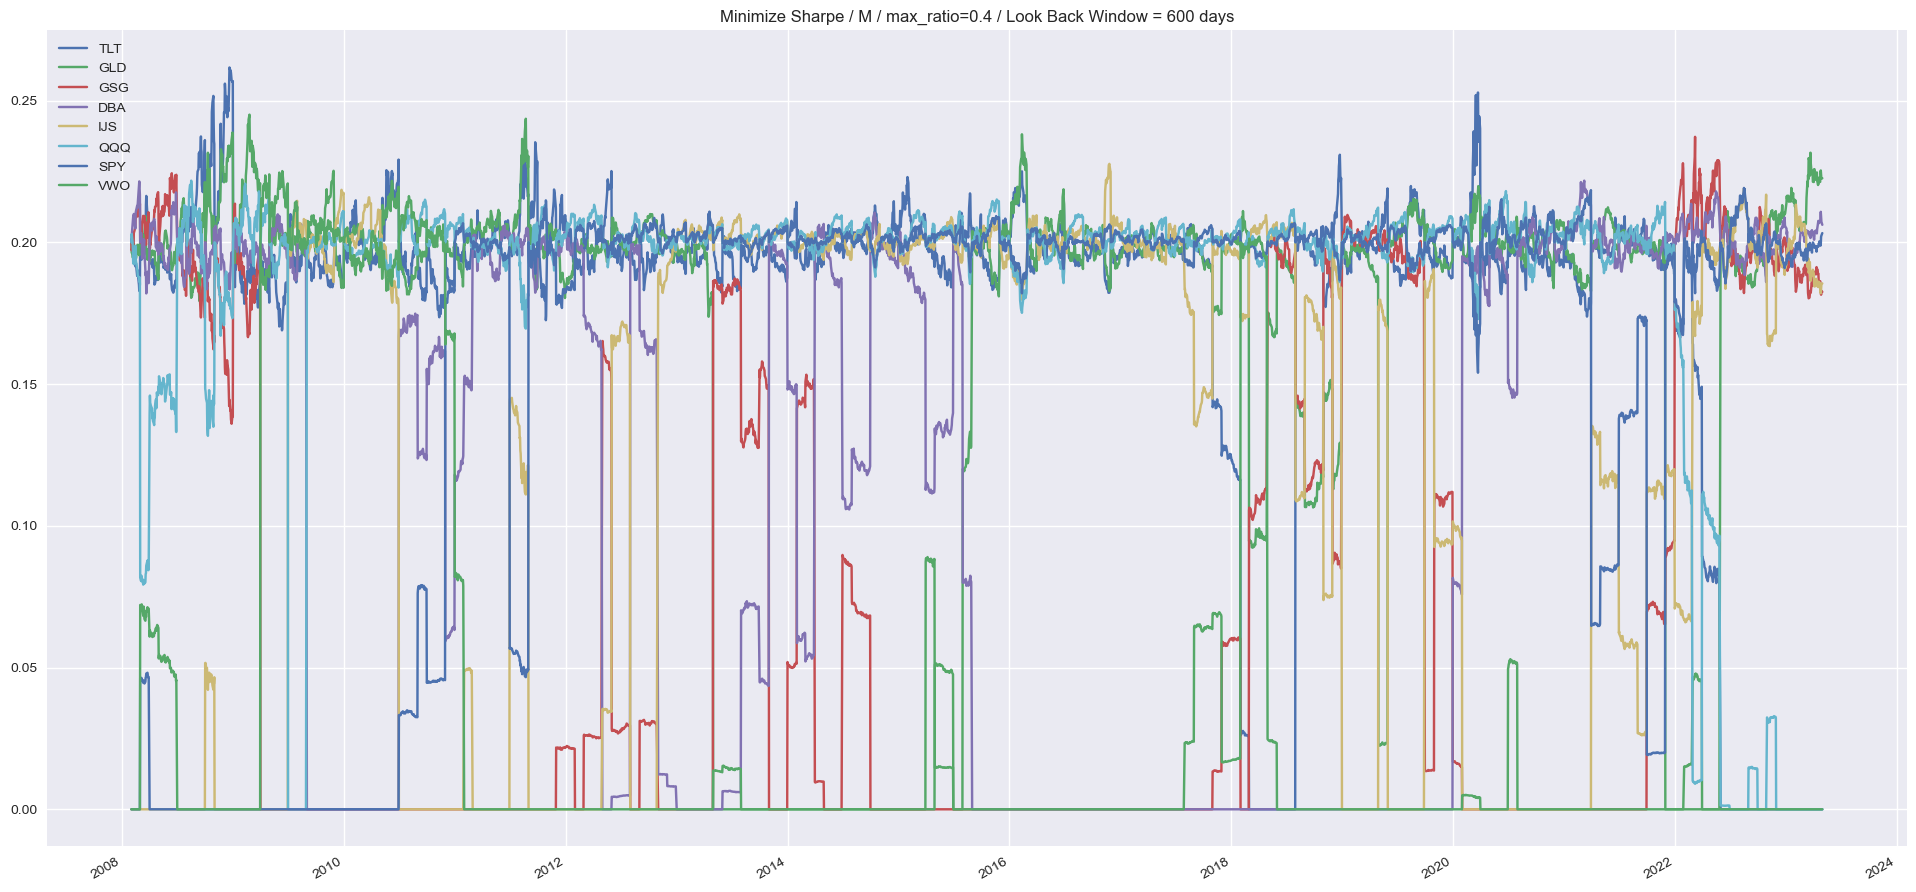

In [223]:
weight_dict["600"].plot(figsize=(24,12),
                        legend=True)
plt.title("Minimize Sharpe / M / max_ratio=0.4 / Look Back Window = 600 days")

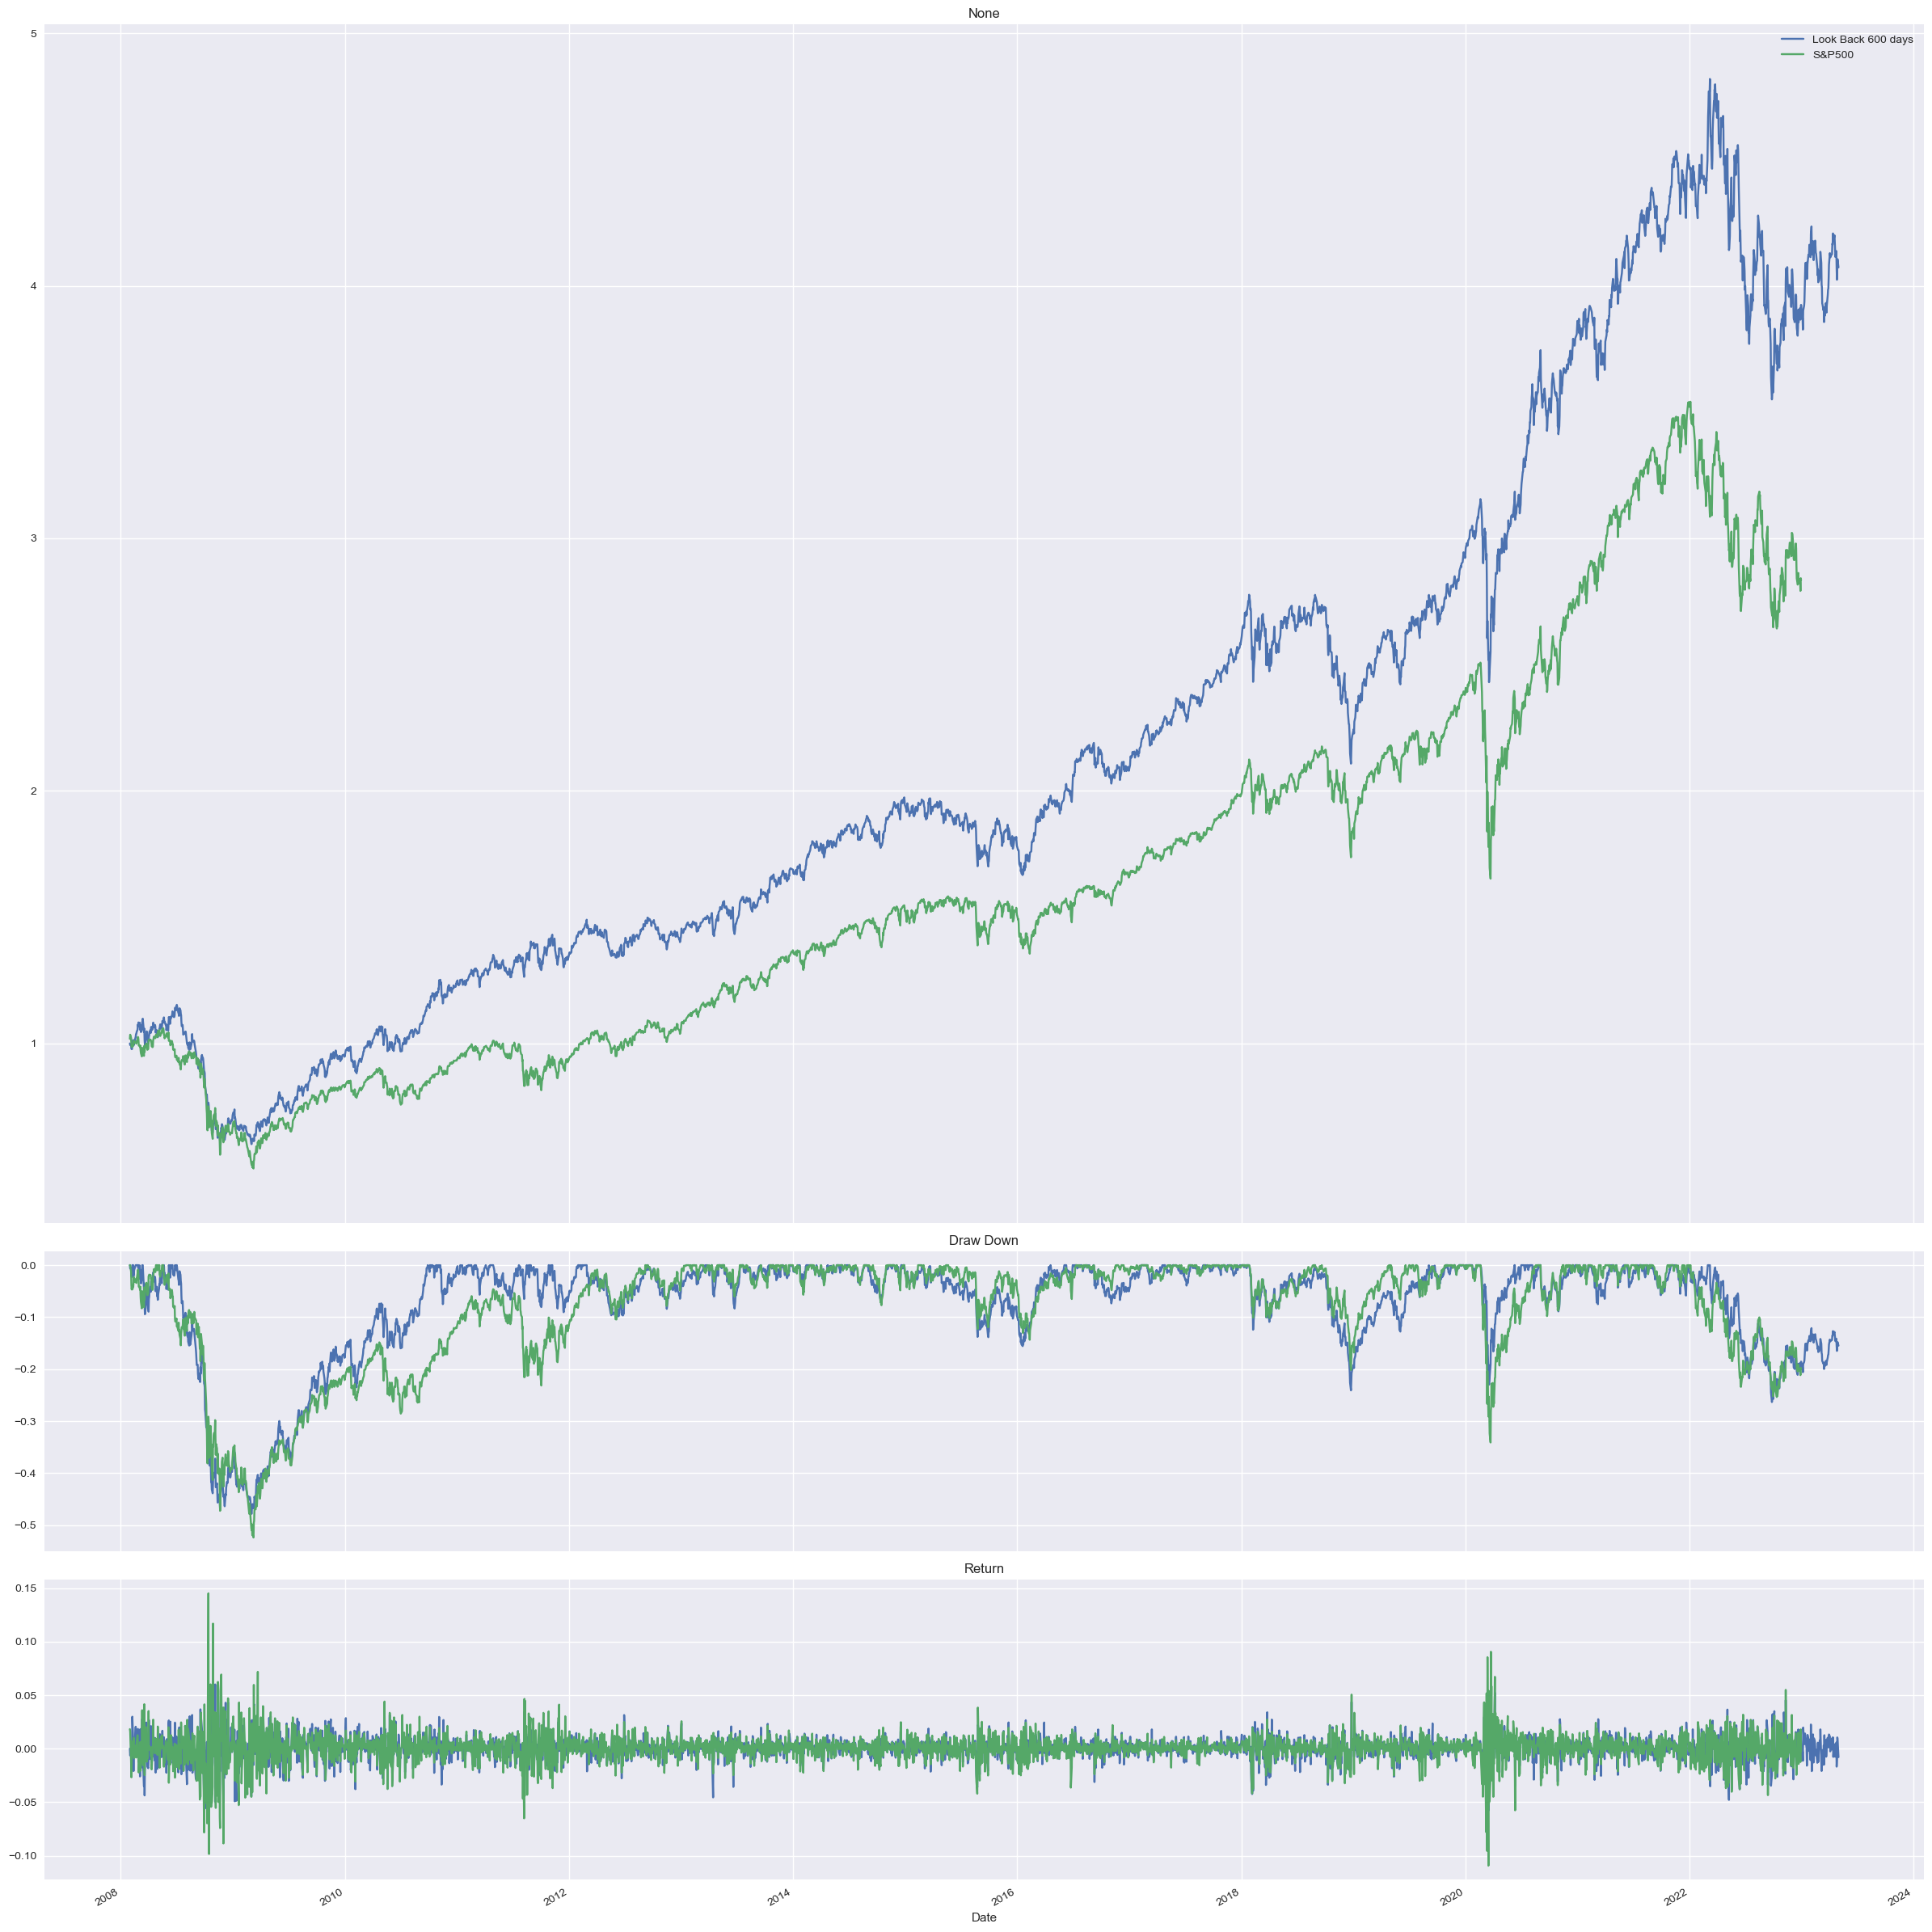

In [235]:
portfolio = result_dict["600 Days"]
spx_sample = spx.loc[portfolio.index[0]:]["Price"] # Series로 변경

draw_return_result({"Look Back 600 days":portfolio,
                    "S&P500": spx_sample},
                   one_plot=True)

In [236]:
st = print_statistics({"Look Back 600 days":portfolio,
                       "S&P500": spx_sample})
st.columns = ["600 days","S&P500"]
st

,600 days,S&P500
CAGR,0.097100,0.070000
Mean,0.107250,0.090320
STD,0.173131,0.207795
MDD,0.478000,0.524000
Sharpe,0.619474,0.434660


In [233]:
from ryu_tool.mytool import run_alpha_regression

run_alpha_regression({"k":portfolio.loc[:"2022-12-31"]},
                     spx_sample,
                     constant=True)

k Regression Result
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.543      
Dependent Variable: y                AIC:                -29249.8223
Date:               2023-05-27 12:43 BIC:                -29237.3601
No. Observations:   3756             Log-Likelihood:     14627.     
Df Model:           1                F-statistic:        4464.      
Df Residuals:       3754             Prob (F-statistic): 0.00       
R-squared:          0.543            Scale:              2.4279e-05 
-----------------------------------------------------------------------
           Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
-----------------------------------------------------------------------
const      0.0001      0.0001     1.6855    0.0920    -0.0000    0.0003
Price      0.4105      0.0061    66.8168    0.0000     0.3984    0.4225
--------------------------------------------------------------------
Omnibus:          

In [ ]:
run_alpha_regression({"Eigenvalue Clipping":portfolio.iloc[1:]},
                     mkt_rtn=spx_sample)